# Subnational Cholera Analysis of Yemen (SCAY)
# Aditya Sai
# April 21, 2019

## Background

Epidemiology and disease processes have always fascinated me, serving as the principal application area of my PhD work. I previously published a [paper](https://www.tandfonline.com/doi/full/10.1080/17513758.2018.1508761?scroll=top&needAccess=true) detailing a parameter estimation study into the cholera epidemic in Yemen from 2017 to 2018. I was able to use mechanistic and phenomenological models of cholera coupled with a global-local parameter estimation algorithm to fit and predict the growth of cholera nationally in Yemen through 2018. Our predictions slightly underestimated the actual values but effectively captured the existing data. 

After publishing the paper, I was interested in looking at more granular data, specifically data pertaining to the 22 governorates, or subnational regions, of Yemen. What kind of data was available and what would it say about how the country dealt with (and is currently dealing with) cholera? Could we fit and predict the growth of cholera differently?  What methods were amenable to this type of analysis? 

Public open-source data pertaining to the epidemic is readily available, thanks to the [Humanitarian Data Exchange (HDX)](https://data.humdata.org/), an open-source data platform part of the United Nation's Office for the Coordination of Humanitarian Affairs. Humanitarian crises such as the War in Yemen and its associated migrant and public health situations have been quantitatively recorded and carefully curated by HDX. I made use of several datasets related to the Yemen cholera crisis to study the process at the subnational level. These datasets are available in this Github repository.

Specifically, in this work, I looked at conducting two specific analyses:
1. Comparison (and categorization) of all governorates on the basis of public health metrics (healthcare facilities, population, cholera incidence) These metrics, or features, can be reduced further using unsupervised learning techniques, like dimensionality reduction, in order to uncover key patterns and/or similarities through low-dimensional projections that preserve as much of the original dataset's properties as possible.
2. Forecasting of future cases in each governorate using time series forecasting methods like ARIMA (autoregressive-integrated-moving average) modeling.

## PART 1: Import relevant libraries and datasets
I first loaded the relevant libraries and datasets from HDX. *scayfunctions.py* contains all the auxiliary functions necessary to complete the analysis. It contains functions for loading datasets, cleaning data, plotting results, and training the models used here. 

In [1]:
import pandas as pd
from scayfunctions import *

Loading the cholera dataset from the specific url in HDX was straightforward. However, some post-processing had to be completed to make sure the numeric data is compliant with the functions I planned to use. I also dropped some unnecessary columns. 

In [2]:
# Load (subnational) governorate-level cholera data
url1 = 'https://docs.google.com/spreadsheets/d/1P0ob0sfz3xqG8u_dxT98YcVTMwzPSnya_qx6MbX-_Z8/pub?gid=0&single=true&output=csv'
cholera = load_dataset(url1)
# Remove commas and convert case data to numeric
cholera['Cases'] = cholera['Cases'].str.replace(',', '')
cholera['Cases'] = pd.to_numeric(cholera['Cases'])
# Drop unnecessary columns
cholera.drop(columns=['COD Gov English','COD Gov Arabic','COD Gov Pcode'],inplace=True)
# Correct governorate-level data in cholera dataset 
clean_governorate_dataset(cholera)

In [3]:
cholera.head(10)

,Date,Governorate,Cases,Deaths,CFR (%),Attack Rate (per 1000)
0,2018-02-18,Amran,103965,176,0.17,89.582
1,2018-02-18,Al Mahwit,62887,151,0.24,86.122
2,2018-02-18,Al Dhale'e,47136,81,0.17,64.438
3,2018-02-18,Hajjah,121287,422,0.35,52.060
4,2018-02-18,Sana'a,76250,123,0.16,51.859
5,2018-02-18,Dhamar,103214,161,0.16,51.292
6,2018-02-18,Abyan,28243,35,0.12,49.477
7,2018-02-18,Al Hudaydah,155908,282,0.18,48.147
8,2018-02-18,Al Bayda,30568,36,0.12,40.253
9,2018-02-18,Amanat Al Asimah,103184,71,0.07,36.489


The cholera dataset contains the cumulative cases, deaths, case fatality rates (CFRs), and attack rates reported from each governorate from May 2017 to February 2018. The CFR is the percentage of cases leading to death, while the attack rate specifies the number of new cases divided by the number of individuals in the population, scaled per 1000 people. These quantities specify the severity of the disease and can often be used to compare outbreaks spatiotemporally.   

Two other important datasets I made use of was related to healthsites and population. I imported these datasets and changed the column names for ease of use.

In [4]:
# Load healthsite data
url2 = 'http://data.humdata.org/dataset/8ed6967a-13c0-4b57-9873-563970a1a35f/resource/af952140-3b69-407c-9d59-a1dab2cca008/download/yemen.csv'
healthsite = load_dataset(url2)

# Load population data
url3 = 'http://data.humdata.org/dataset/8ded1878-b737-4922-adf4-05216bd46674/resource/88590116-ea8f-4daf-ae32-3db8a015a319/download/yem_pop_adm1.csv'
population = load_dataset(url3)

# Retain only governorate name and total population
population = population.filter(items=['admin1Name_en','T'])
population.rename(columns={'admin1Name_en':'Governorate','T':'Population'},inplace=True)

In [5]:
healthsite.head(5)

,X,Y,source_url,what3words,upstream,name,completeness,uuid,date_modified,source,version,type,physical-address,phone,email,url
0,43.441500,12.920622,http://www.openstreetmap.org/node/4695581007,assimilate.mulled.billows,OpenStreetMap¶n4695581007,Al Huraqiyah HU,29.41%,88f9047cb986499f9be375dbc41996ed,2017/02/20 14:43:35+00,OpenStreetMap,2,clinic,NaN,NaN,NaN,NaN
1,43.241791,13.319845,http://www.openstreetmap.org/node/4718604079,plays.glassy.doubter,OpenStreetMap¶n4718604079,Al Mokha hospital,29.41%,67dff74cec7447a68de07edb810c6db4,2017/03/05 15:50:07+00,OpenStreetMap,2,hospital,NaN,NaN,NaN,NaN
2,43.269135,13.219313,http://www.openstreetmap.org/node/4695580717,infinitely.sneaked.gleaned,OpenStreetMap¶n4695580717,Al Wahijah HU,29.41%,0f3accb17b9a4485a203977d50d893c9,2017/02/20 14:43:31+00,OpenStreetMap,2,clinic,NaN,NaN,NaN,NaN
3,44.892089,12.977752,http://www.openstreetmap.org/node/4332319016,welder.invocations.marbles,OpenStreetMap¶n4332319016,Al Waht Hospital,35.29%,f4f6e886a0eb4ac5a8394cba84d05727,2016/08/09 19:59:41+00,OpenStreetMap,2,hospital,Al Waht main street,NaN,NaN,NaN
4,45.038077,12.805794,http://www.openstreetmap.org/way/173088502,answers.timing.craftsman,openstreetmap¶w173088502,Al-Jumhuriah Hospital,35.29%,b3f178b187204c4da65d3ee5b61950a6,2015/12/11 10:51:22.924+00,OpenStreetMap,2,hospital,NaN,NaN,NaN,NaN


The *healthsite* dataset contains geogrpahic coordinates of various health facilities in Yemen, along with certain descriptors associated with OpenStreetMap. I made use of the latitude (X) and longitude (Y) data when I visualize and tabulate the number of healthsites in each governorate. 

In [6]:
population.head(10)

,Governorate,Population
0,Abyan,567997
1,Aden,925002
2,Al Bayda,760007
3,Al Dhale'e,720002
4,Al Hudaydah,3189003
5,Al Jawf,589005
6,Al Maharah,149997
7,Al Mahwit,695005
8,Amanat Al Asimah,2948471
9,Amran,1052004


The *population* dataset simply contains each governorate's estimated total population as of 2017. 

## PART 2: Geospatial Visualization

I found, as an additional step to visualization, that plotting certain features over a geographical map of Yemen would be extremely helpful to understanding the geospatial aspects of the epidemic. An important package for geospatial visualization is the *geopandas* package, which extends the dataframe functionality to geospatial data. To create a geodataframe, I read in a shapefile, which specifies the geometric parameters for a target map. I also decided to count the number of healthsites in each governorate by tracking the number of healthsites enclosed in the polygons describing each governorate. 

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Load shapefile 
shp = gpd.read_file('shapefiles/governorate.shp')

# Count number of healthsites in each governorate 
count_healthsites(shp,healthsite)

Then, I combined all the previously imported datasets together so that I could plot a map of Yemen with certain features superimposed on top. In combining these datasets, I kept only the cholera data pertaining to the most recently recorded data in February 2018, which represents the most recently known totals for cases and deaths. The combined dataset contained the following features:
1. Population
2. Number of healthsites
3. Number of cholera cases
4. Number of cholera deaths
5. CFR
6. Attack Rate
7. Perimeter of the polygon describing each governorate
8. Area of the polygon describing each governorate
9. Geometric coordinates for plotting each governorate

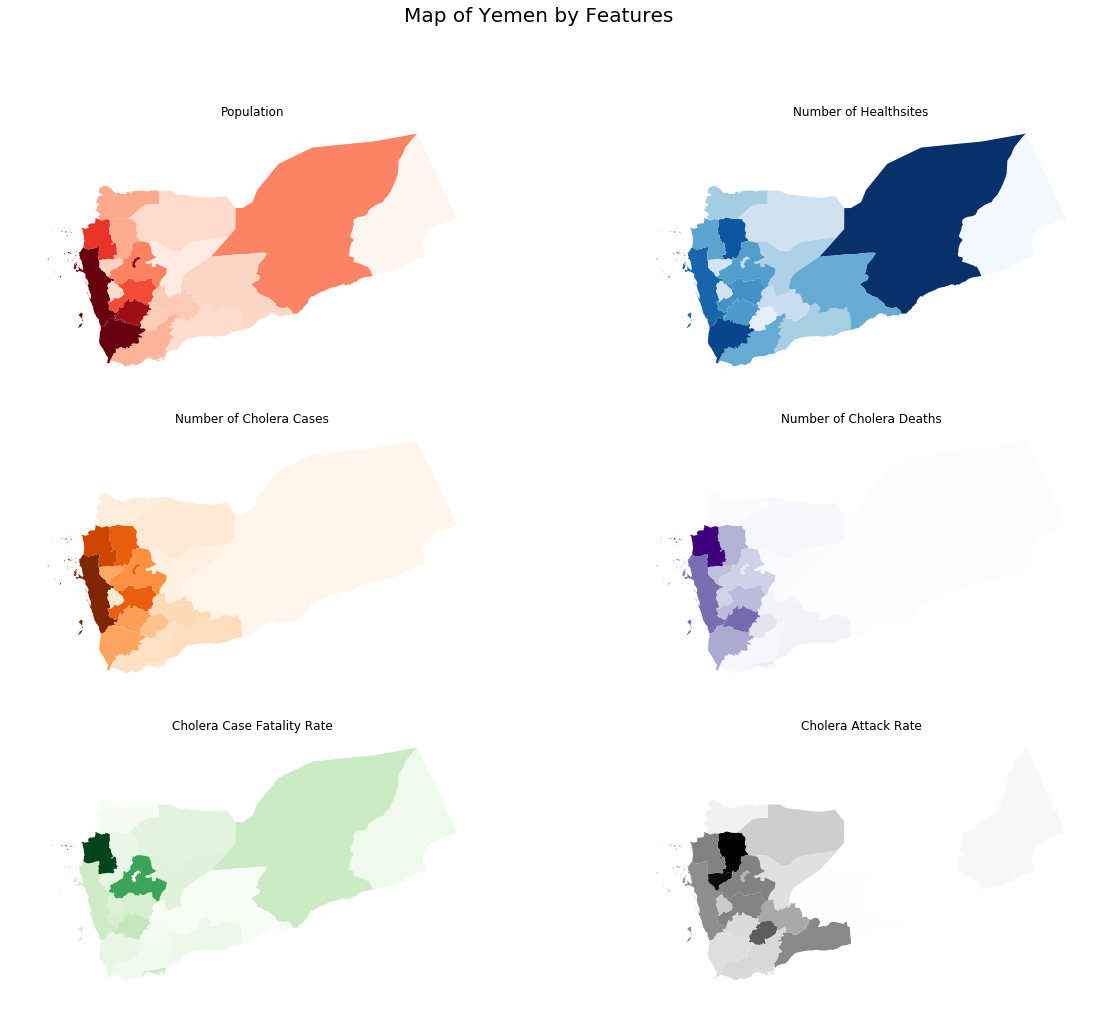

In [8]:
# Aggregate geographic, cholera, population and healthsite data
overall = combine_datasets(cholera,population,shp)

# Plot (separate) geographic maps of Yemen illustrating relevant statistics    
plot_maps(overall)

Population centers like **Aden** and **Sanaa**, the capital of Yemen, are concentrated in the west and are likely the areas most devastated by the ongoing civil war and the rampant cholera epidemic. More people have contracted and died from cholera in these areas. The eastern governorate **Hadramaut** actually has a high population, and the highest number of healthsites. Generally speaking, cholera has affected western Yemen the most, which also happens to be the population center of Yemen. 

## PART 3: Comparing Governorates using Principal Components Analysis (PCA)

To further explore the relationships between these governorates, I used an unsupervised dimensionality reduction method, principal components analysis, to collapse the dataset onto a lower dimensional space that retained as much of the original variance in the dataset as possible. PCA determines a set of uncorrelated features that minimize information redundancy and noise resulting from high-dimensional datasets. The number of principal components onto which the original dataset is projected should be less than the number of original features. This would make it easy to visualize and understand if certain governorates share a similar holistic "profile" with respect to the original features. But first, I looked at the pairwise relationships between each feature. 

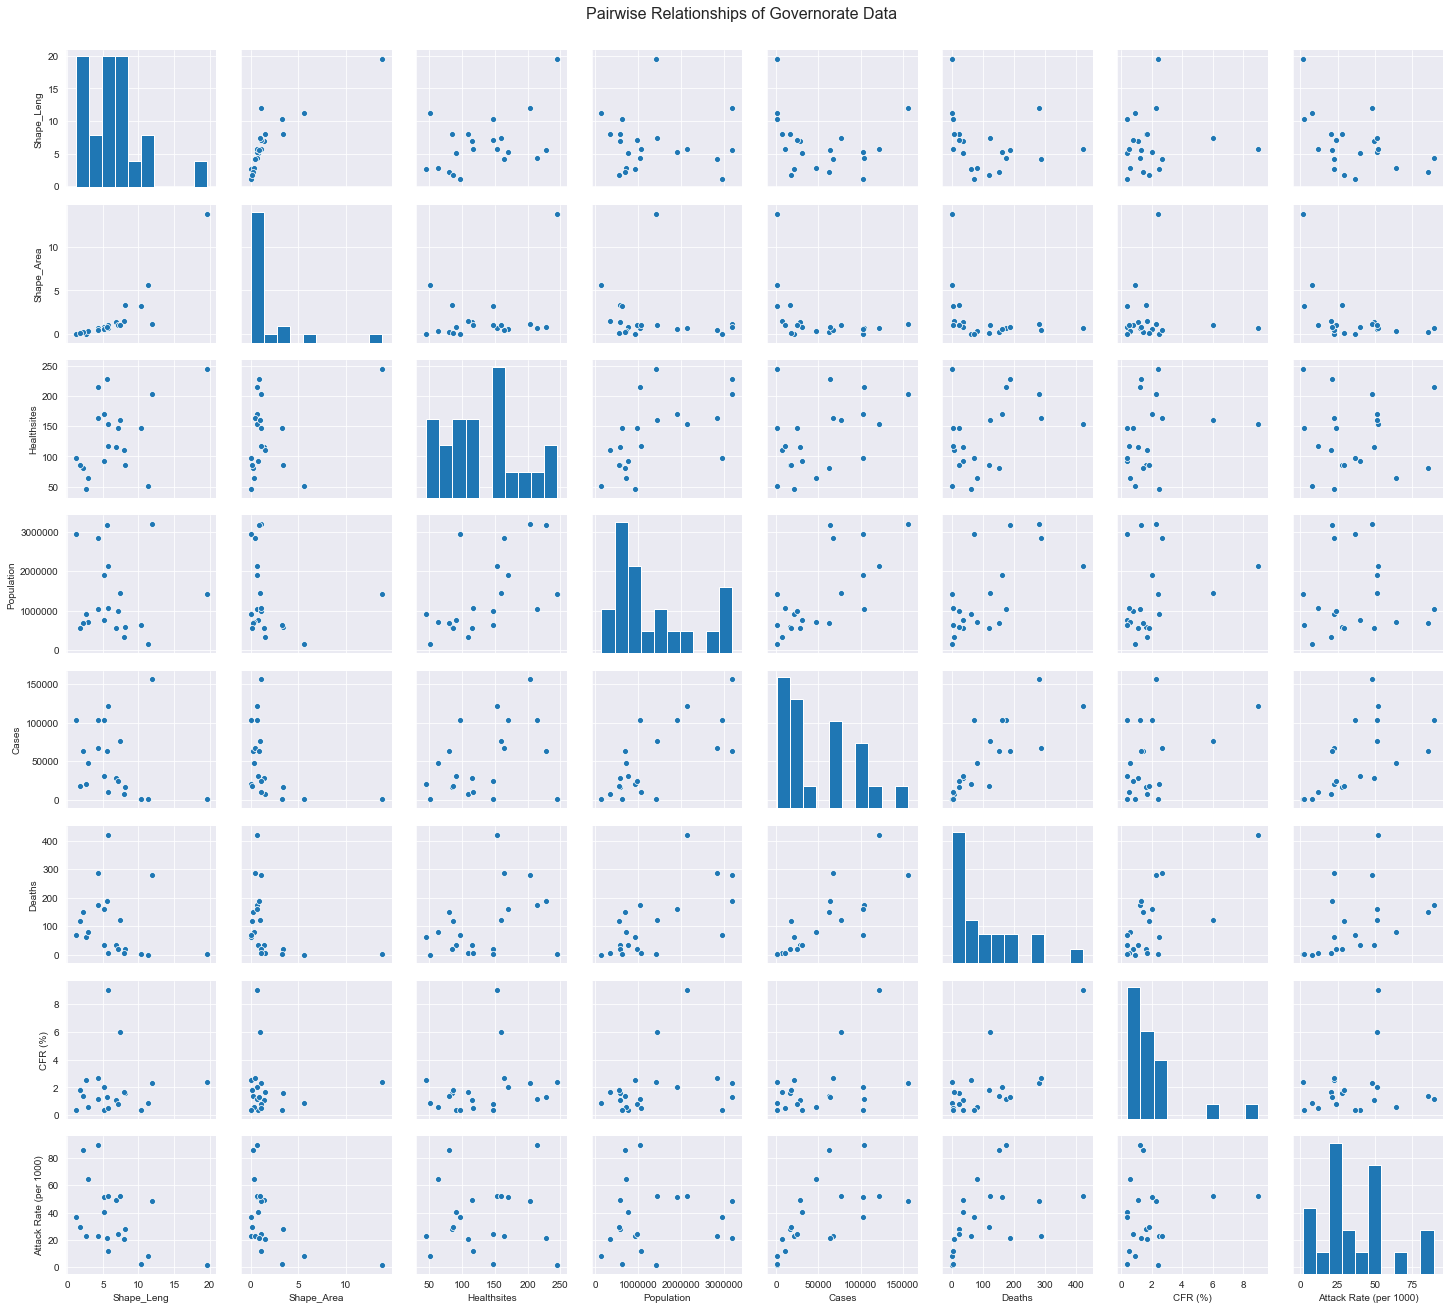

In [9]:
import numpy as np
import seaborn as sns

# Set grid style using seaborn
sns.set_style("darkgrid")

# Remove geometry column
X = overall.drop(columns=['geometry'])

# Plot pairwise relationships of governorate data
g = sns.pairplot(X)
g.fig.suptitle('Pairwise Relationships of Governorate Data',fontsize=16)
g.fig.subplots_adjust(top=.95,bottom=.1)

Plenty of the features showed exponential-like distributions where the large majority of instances had very small values for each feature. The majority of governorates have small areas and CFRs. The number of cases, deaths, and healthsites scaled with the population. To perform the PCA, we first standardized each feature by subtracting the mean and dividing by the standard deviation. This is done to avoid certain features from dominating the PCA procedure. I also looked at how much variance was captured by the first two principal components I decided to keep. 

In [10]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Standardize data prior to PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xsc = sc.fit_transform(X)

# Standard PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
Xpca = pca.fit_transform(Xsc)

# Print percentage of total variance explained through first two PCs
print('Explained percentage of variance by first two principal components: %.2f' %(pca.explained_variance_ratio_.sum()))

Explained percentage of variance by first two principal components: 0.73


73% of the variance was retained through this standard, linear PCA procedure. I then examined the projections of each governorate onto the axes of the orthogonal principal components. It was easy to see that there are three distinct groups. While the axes themselves may not have any inherent meaning for this application, the relative positioning of these regions may shed some light on which areas had similar characteristics demographically and experienced the cholera outbreak similarly. k-means clustering was handy in quickly clustering the governorates. 

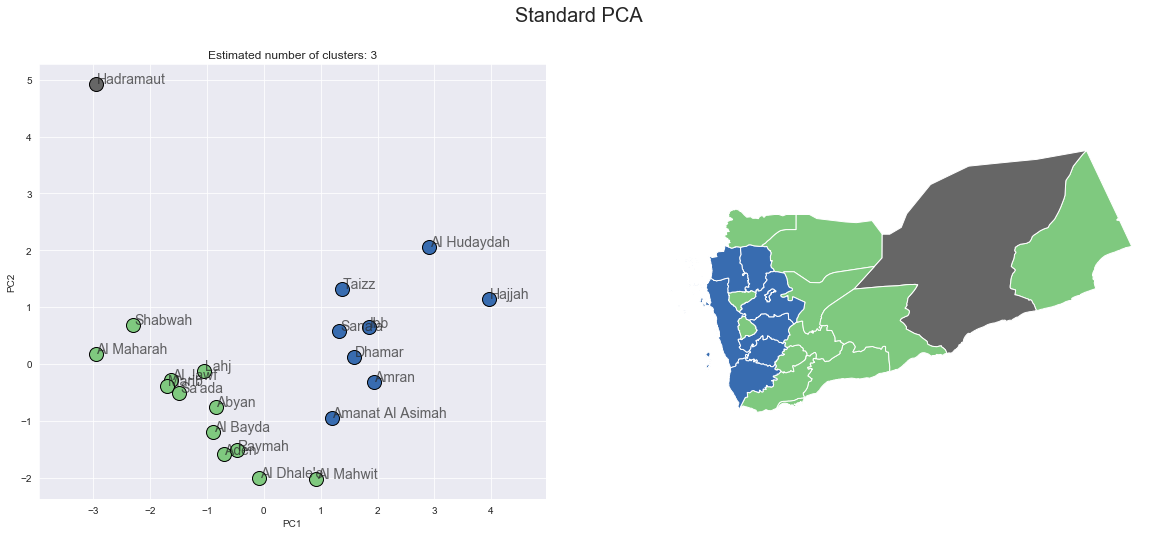

In [11]:
# K-means clustering of standard PCA
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state = 0)
labels = kmeans.fit_predict(Xpca)

# Plot clusters along with map representations
plot_pca(Xpca,overall,labels,'Standard PCA')

There appears to be some geospatial clustering taking place. The blue cluster experienced the worst of the outbreak and is probably the highest risk area. The green cluster had fewer people, and healthsites, so there was less risk in those areas. **Hadramaut** stands out as an outlier fairly far away from the rest of the data. With a moderately sized population and a large number of healthsites, it seems to have developed a unique profile in dealing with cholera that distinguishes it from the rest of the country. 

Kernel PCA applies nonlinear dimensionality reduction by using kernels. Kernels enable data to projected onto a higher-dimensional space, which may seem counterintuitive when considering application of a dimensionality reduction method like PCA. However, this movement to a new higher dimensional feature space improves the ability of PCA to linearly separate the (transformed) data. I also looked at Kernel PCA to determine if there was a better, and clearer, way to separate the blue and green clusters that were fairly close.

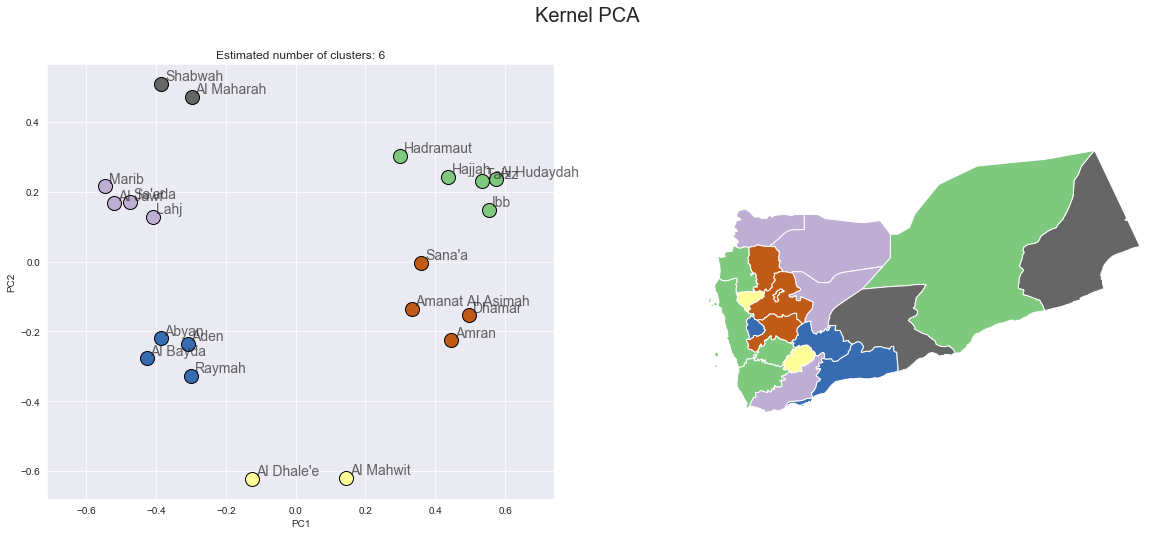

In [12]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 2, kernel = 'rbf')
Xkpca = kpca.fit_transform(Xsc)

# K-means clustering of Kernel PCA
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state = 0)
labels = kmeans.fit_predict(Xkpca)

# Plot clusters along with map representations
plot_pca(Xkpca,overall,labels,'Kernel PCA')

With a Gaussian kernel, I found 6 clearly separated clusters that also would seem to indicate some kind of risk category. In my opinion, from highest to lowest risk, would be the green, brown, black, purple, blue and yellow clusters. Interestingly, the kernel PCA arrangement seems to preserve some of the original relationships found in the standard PCA. For example, the green cluster in the standard PCA dissolved into the yellow, blue and purple clusters in the kernel PCA. There is some decomposition of the standard PCA clusters into the kernel PCA clusters.

## PART 4: Time Series Modeling & Forecasting (National)

I next wanted to take a look at the actual series of observations describing the number of cases in each governorate over the nine months of data available, in order to predict the future number of cases. These observations are considered to be time series. Time series are discrete points indexed by time. Unlike regression-based techniques, time series-based techniques account for the ordering of the data. Hopefully, there are sufficient time points to identify the signal necessary to extrapolate future cases. I examined the entire national data first by loading the relevant dataset. 

In [13]:
# Load national cholera dataset
url4 = 'https://docs.google.com/spreadsheets/d/1P0ob0sfz3xqG8u_dxT98YcVTMwzPSnya_qx6MbX-_Z8/pub?gid=27806487&single=true&output=csv'
country = load_dataset(url4)

# Necessary pre-processing
country = country.drop(country.index[0])
country[country.columns[1:5]] = country[country.columns[1:5]].apply(pd.to_numeric,errors='coerce')

I then resampled the national data according to a weekly frequency. The time series model that I decided to use for training and prediction is known as ARIMA, short for autoregression-integrated-moving average. ARIMA is a generalized regression model that uses previous values of a target, or dependent, variable (*autoregression*), differences between values of the variable (*integrated*), and previous values of prediction errors (*moving average*), to make predictions. It requires the time series to be *stationary*, meaning its statistical properties should be constant over time. Three parameters, *(p, d, q)*, describe the degree to which an ARIMA model employs autoregression, differencing, and moving average operations, respectively. For each time series, I selected the combination of these parameters that minimized the cross-validation root-mean-squared error (RMSE). 

I wanted to select the model that best forecast cases 4 weeks into the future, by using [time series cross validation](https://robjhyndman.com/hyndsight/tscv/): 
1. I trained the model with a training set whose initial size was a certain percentage (70%) of the entire dataset. 
2. I predicted the number of cases 4 weeks into the future using the model trained in Step 1, and stored this value in the prediction set. I also stored the actual value in the dataset 4 weeks ahead in the test set. 
3. I added an additional observation to the training set and proceeded to Step 1. 

I continued this process until there were no more test values available for comparison. The final cross-validation error was the RMSE between the prediction and test sets. Different combinations of *(p, d, q)* were evaluated. I ultimately picked those parameters that minimized the cross-validation error. This form of cross-validation is useful in situations where the dataset is relatively small, as is the case here. It makes use of the entire dataset for training, testing, and validation purposes. In total, there were between 40 and 60 observations for each governorate and the nation. 

In [14]:
# Resample national data and train ARIMA model
z = extract_weekly_data(country)
pred,_,_ = train_ARIMA_model(z,'Yemen',False,country.iloc[0,0],0.7,4)

The RMSE of our forecasts is 248.55


After training the model, I got a RMSE of 248.55 cases. This may or may not be significant, depending in part on the quality of the visualization. I plotted both the actual cases and the ARIMA model predictions.

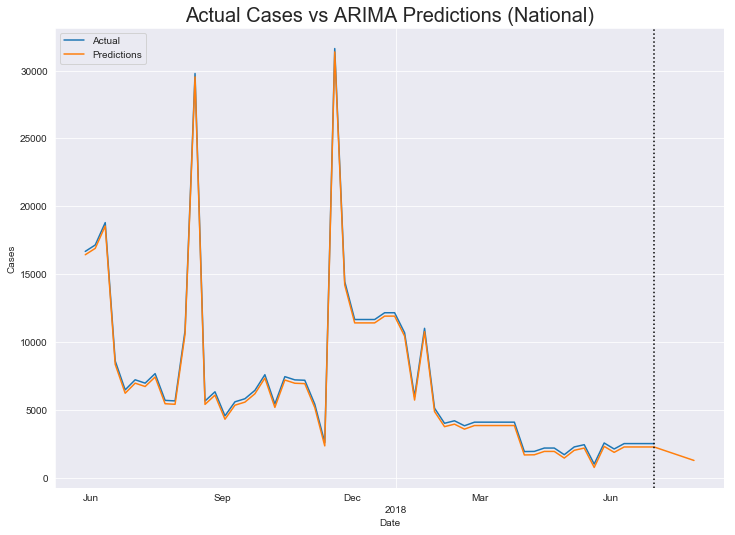

In [15]:
# Plot results related to national data
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(z,label='Actual')
ax.plot(pred,label='Predictions')
ax.axvline(pd.to_datetime(country.iloc[0,0]),color='k',ls=':')
ax.set_title('Actual Cases vs ARIMA Predictions (National)',fontsize=20)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator((3,6,9,12)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.legend()
fig.subplots_adjust(top=.9,bottom=.1)

The vertical dashed line indicates the last date for which actual data was available and when the forecasting begins. The model fit the data fairly well and there was an indication that future cases would decline. 

## STEP 5: Time Series Modeling & Forecasting (Subnational)

I extended the time series modeling and forecasting done to Yemen nationally to the individual governorates. We had data for only 21 of the 22 governorates, but the **Hadramaut** dataset was split into **Say''on** and **Moklla** datasets. Therefore, we modeled 22 time series. 

In [16]:
import warnings
warnings.filterwarnings("ignore")
# Extract names of all governorates
regions = cholera['Governorate'].cat.categories.tolist()
results = pd.DataFrame(columns=['Region','Values','Cases']) 
# Iterate through all governorates
for name in regions:
    tmp1 = pd.DataFrame(columns=['Region','Values','Cases']) 
    tmp2 = pd.DataFrame(columns=['Region','Values','Cases'])       
    # Load specific subnational data
    region = cholera[cholera['Governorate'] == name]
    # Extract (average) weekly subnational data
    y = extract_weekly_data(region,name,False)
    # Train ARIMA model
    pred,_,_ = train_ARIMA_model(y,name,False,region.iloc[0,0],0.7)
    # Store results from each governorate
    tmp1['Cases'] = y
    tmp1['Region'] = name
    tmp1['Values'] = 'Actual'
    tmp2['Cases'] = pred
    tmp2['Region'] = name
    tmp2['Values'] = 'Predicted'
    # Concatenate to overall results dataframe
    results = pd.concat([results, tmp1, tmp2])
results['Date'] = results.index

The RMSE of our forecasts is 7.02
The RMSE of our forecasts is 7.68
The RMSE of our forecasts is 125.16
The RMSE of our forecasts is 12.46
The RMSE of our forecasts is 751.19
The RMSE of our forecasts is 94.0
The RMSE of our forecasts is 0.14
The RMSE of our forecasts is 21.76
The RMSE of our forecasts is 321.28
The RMSE of our forecasts is 54.68
The RMSE of our forecasts is 615.69
The RMSE of our forecasts is 683.61
The RMSE of our forecasts is 437.31
The RMSE of our forecasts is 342.79
The RMSE of our forecasts is 72.65
The RMSE of our forecasts is 0.03
The RMSE of our forecasts is 67.23
The RMSE of our forecasts is 69.29
The RMSE of our forecasts is 287.47
The RMSE of our forecasts is 0.73
The RMSE of our forecasts is 5.49
The RMSE of our forecasts is 39.45


The RMSEs vary depending on the existing population and number of cases in each governorate. Nevertheless, some of the errors do appear extreme. I verified the quality of the models visually. 

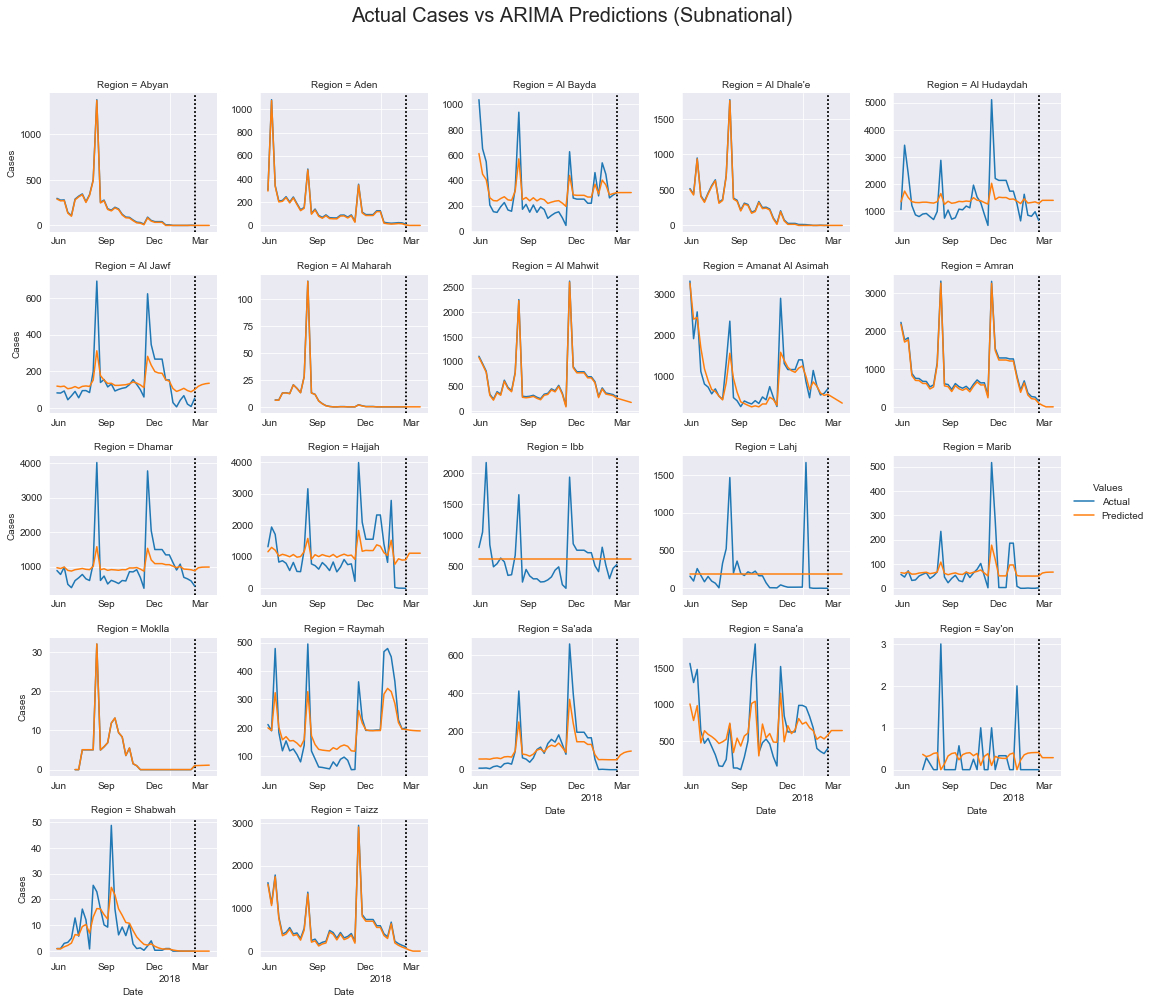

In [17]:
# Plot results related to subnational data
import seaborn as sns
import matplotlib.dates as mdates

def plot_timestamp(data,**kwargs):
    plt.axvline(pd.to_datetime('2018-02-18'),color='k',ls=':')

g = sns.FacetGrid(results,col='Region',col_wrap=5,hue='Values',sharey=False)
g = g.map(plot_timestamp,'Date')
for i in range(len(g.axes)):
    g.axes[i].xaxis.set_major_locator(mdates.YearLocator())
    g.axes[i].xaxis.set_minor_locator(mdates.MonthLocator((3,6,9,12)))
    g.axes[i].xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
    g.axes[i].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
g = g.map(sns.lineplot,'Date','Cases')
g.add_legend()
g.fig.suptitle('Actual Cases vs ARIMA Predictions (Subnational)',fontsize=20)
g.fig.subplots_adjust(top=.9,bottom=.1)

Seven of the governorates have predictions that perfectly overlap with actual data. Other governorates, like **Al Bayda**, **Amanat Al Asimah**, **Raymah**, **Saada**, **Sanaa**, and **Shabwah** show strong qualitative fits. However, **Ibb** and **Lahj** were not accurately approximated as those models did not contain any of the ARIMA components in the resulting models. The models were simply a straight line through the mean of the dataset. Three of the six largest governorates, **Al Hudaydah**, **Dhamar**, and **Hajjah**, were poorly modeled as well, although the qualitative trends were captured. The poor fits may be explained by the lack of data. Only 39 weekly data points were available for modeling. Potential seasonality effects that could have better aligned the model to the data would be difficult to discern without a full year's worth of data or more. Seasonal ARIMA may be more appropriate in these cases. The forecasts for the next month show fewer new cases being added, which matches the conventional wisdom about public health outbreaks after several peaks have been experienced.     

## Takeaways

> **Dimensionality reduction of governorate-level data reveals distinct "risk" categories**

Analyzing a multivariate subnational dataset to tease out inherent patterns and trends can often be difficult, if not intractable. With public health data, there is also the question of what features best describe the dataset. I was able to demonstrate somewhat clear delineations between groups of governorates that confirmed certain geographical associations while refuting others. PCA enables maximal propagation of variance from high to low dimensional datasets. It is this variance that was key in separating the various governorates. In the future, I look forward to adding additional features possibly external to public health, like displacement and migration statistics, or public infrastructure information, that would enable clearer groupings. Furthermore, adding an additional principal component would only enhance the separation, as we only captured about 70% of the original variance. Transforming the dataset with a Gaussian kernel also proved helpful and further isolated nearby points. The resulting clusters highlight apparent disparities in how each governorate experienced the outbreak. It serves as a useful indicator of susceptibility and exposure to cholera in light of population and healthcare infrastructure considerations. The west, central, south, east, and surrounding areas around the capital formed their own clusters. Despite not adding any specific geographic information, the governorates were found to organize partially along these lines, suggesting that the data inherently contains this information. The **Hadramaut** governorate stood out as an exception when standard PCA was applied. Another study that may be intriguing to follow up on may be to change the cases and deaths column of the dataframe iteratively to see what effect this would have on the PCA. Animating this "dynamic" PCA may show some interesting movement of the governorates along the principal component axes.    

> **ARIMA modeling, coupled with time series cross validation, captures limited case data effectively** 

My intent in exploring the time series pertaining to cholera cases was not just to capture the existing trends in the record, but to estimate the growth of the outbreak in individual governorates and the country as a whole. The best model performance was observed generally through differencing, which basically appeared to mimic the case data. Most models were able to follow the qualitative trends fairly closely, but failed to match the peaks in the dataset. The forecasts were obtained through time series cross validation, an effective technique for properly incorporating training and test set observations to assess the quality of predictions. I chose time series cross validation primarily because of the limited size of the datasets.  The limited datasets may be largely responsible for why certain models performed poorly. In the future, I would want to look at larger datasets, possibly including seasonal effects as previously mentioned, and including the influences of exogenous variables not present in the data currently. Moreover, I also want to confirm the forecasts made by the models independently.    